[View in Colaboratory](https://colab.research.google.com/github/eswens13/cs6955/blob/dev/hw1/swenson_homework1_neural_net.ipynb)

# Homework 1: Classifiers

# Two-layer Neural Network classifier
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [0]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Define a two-layer neural network classifier

We will use the class `TwoLayerNet` below to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.  Most of the code for this class already exists, but you will need to write code of your own to finish it.  Follow the instructions in the TODO sections.

In [0]:
class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network. The net has an input dimension of
  N, a hidden layer dimension of H, and performs classification over C classes.
  We train the network with a softmax loss function and L2 regularization on the
  weight matrices. The network uses a ReLU nonlinearity after the first fully
  connected layer.

  In other words, the network has the following architecture:

  input -> fully connected layer -> ReLU -> fully connected layer -> softmax

  The outputs of the second fully-connected layer are the scores for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:

    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0):
    """
    Compute the loss and gradients for a two layer fully connected neural
    network.

    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.

    Returns:
    If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].

    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    """
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape

    # Compute the forward pass
    scores = None
    #############################################################################
    # TODO: Perform the forward pass, computing the class scores for the input. #
    # Store the result in the scores variable, which should be an array of      #
    # shape (N, C).                                                             #
    #############################################################################

    # To get the output of hidden layer 1, we dot product the input sample
    # with the weights matrix for hidden layer 1 and add the biases.
    layer_1_output = np.dot(X, W1) + b1
    
    # Then we apply a ReLU activation function (i.e. max(0, value)).
    layer_1_activation = np.maximum(layer_1_output, 0)
    
    # To get the output of the second layer, we dot product the output from
    # layer 1 with layer 2 weights matrix and add the biases. This gives us the
    # raw scores (without softmax being applied).
    scores = np.dot(layer_1_activation, W2) + b2
    
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################
    
    # If the targets are not given then jump out, we're done
    if y is None:
      return scores

    # Compute the loss
    loss = None
    #############################################################################
    # TODO: Finish the forward pass, and compute the loss. This should include  #
    # both the data loss and L2 regularization for W1 and W2. Store the result  #
    # in the variable loss, which should be a scalar. Use the Softmax           #
    # classifier loss.                                                          #
    #############################################################################
    
    # Softmax loss function
    # Calculate the loss for each sample.
    #print("Scores: ", scores)
    max_vals = np.amin(scores, axis=1)
    #print("Max Vals: ", max_vals)
    scores -= max_vals[:, np.newaxis]
    probs = np.exp(scores)
    #print("Probs: ", probs)
    denoms = np.sum(probs, axis=1)
    #print ("Denoms: ", denoms)
    norm_probs = probs / denoms[:,np.newaxis] # broadcast division (divide each row by sum)
    #print("Norm Probs: ", norm_probs)
    l_vec = -1 * np.log(norm_probs[np.arange(y.shape[0]),y])
    #print("loss vec: ", l_vec)
    
    # Then take the average over all samples.
    average_loss = np.mean(l_vec)
    
    # Add L2 Regularization
    # TODO: Do I include the bias terms here?
    w1_reg = np.sum(np.square(W1))
    w2_reg = np.sum(np.square(W2))
    
    loss = average_loss + reg * (w1_reg + w2_reg)
    
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    # Backward pass: compute gradients
    grads = {}
    #############################################################################
    # TODO: Compute the backward pass, computing the derivatives of the weights #
    # and biases. Store the results in the grads dictionary. For example,       #
    # grads['W1'] should store the gradient on W1, and be a matrix of same size #
    #############################################################################
    
    # This is the gradient of the softmax function w.r.t. the raw scores. We
    # store this result because it will propagate back through everything else.
    import copy
    base_grad = copy.deepcopy(norm_probs)
    base_grad[np.arange(y.shape[0]), y] -= 1
    base_grad /= X.shape[0]
    
    # Gradient of loss w.r.t. b2 is just this base gradient. (Sum the columns
    # since each row is the backpropagation of a single sample. Add gradient
    # contributions from each sample.) Don't forget to divide by the same factor
    # the loss is divided by.
    grads['b2'] = np.sum(base_grad, axis=0)
    
    # Add the gradient contribution from the regularization term.
    #grads['b2'] += 2 * reg * b2
    
    # Gradient of loss w.r.t. W2 is the base gradient dotted with the output
    # from the ReLU activation.
    grads['W2'] = np.dot(layer_1_activation.T, base_grad)
    grads['W2'] += 2 * reg * W2
    
    # Gradient of loss w.r.t. b1 is the base gradient dotted with the W2 matrix.
    # Then we need to remove any elements less than 0. (Again, sum the columns.)
    b1_grad = np.dot(base_grad, W2.T)
    b1_grad[layer_1_output < 0] = 0
    grads['b1'] = np.sum(b1_grad, axis=0)
    #grads['b1'] += 2 * reg * b1
    
    # Gradient of loss w.r.t. W1 is the base gradient dotted with W2 and X.
    # Again, remove any elements less than 0.
    grads['W1'] = np.dot(X.T, b1_grad)
    grads['W1'] += 2 * reg * W1
    
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this neural network using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO: Create a random minibatch of training data and labels, storing  #
      # them in X_batch and y_batch respectively.                             #
      #########################################################################
      inds = np.random.choice(X.shape[0], size=batch_size)
      X_batch = X[inds, :]
      y_batch = y[inds]
      #########################################################################
      #                             END OF YOUR CODE                          #
      #########################################################################

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      #########################################################################
      # TODO: Use the gradients in the grads dictionary to update the         #
      # parameters of the network (stored in the dictionary self.params)      #
      # using stochastic gradient descent. You'll need to use the gradients   #
      # stored in the grads dictionary defined above.                         #
      #########################################################################
      self.params['W1'] -= learning_rate * grads['W1']
      self.params['b1'] -= learning_rate * grads['b1']
      self.params['W2'] -= learning_rate * grads['W2']
      self.params['b2'] -= learning_rate * grads['b2']
      #########################################################################
      #                             END OF YOUR CODE                          #
      #########################################################################

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.

    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.

    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
    y_pred = None

    ###########################################################################
    # TODO: Implement this function; it should be VERY simple!                #
    ###########################################################################
    
    # Do the same thing we do in the loss except for just get the label of the
    # highest score without computing loss.
    layer_1_output = np.dot(X, self.params['W1']) + self.params['b1']
    layer_1_activation = np.maximum(layer_1_output, 0)
    scores = np.dot(layer_1_activation, self.params['W2']) + self.params['b2']
    y_pred = np.argmax(scores, axis=1)
    
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return y_pred




In [0]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Notice that the `loss` method in the `TwoLayerNet` class above is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs, then check your implementation below.

In [5]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [6]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [7]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print(ix, grad[ix])
    it.iternext() # step to next dimension

  return grad
    
# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 4.447646e-11
W2 max relative error: 3.440708e-09
b1 max relative error: 2.738421e-09
W1 max relative error: 3.561318e-09


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the method `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

iteration 0 / 100: loss 1.241994
Final training loss:  0.01714960793873202


Text(0.5,1,'Training Loss history')

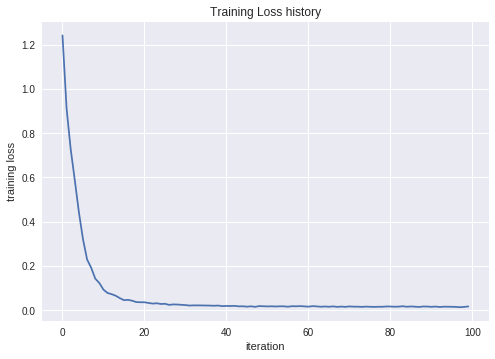

In [8]:
net = init_toy_model()
stats = net.train(X, y, X, y,
                  learning_rate=1e-1, reg=5e-6,
                  num_iters=100, verbose=True)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [9]:
from keras.datasets import cifar10

def get_CIFAR10_data(num_training=49000, num_validation=1000,
                     num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    # All the data comes in the uint8 format, so we need to convert
    # it to floats so that we compute numbers greater than 255.
    X_train = X_train.astype(np.float)
    X_test = X_test.astype(np.float)
    # Also, for convenience we flatten the class arrays.
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    # Split the data into train, val, and test sets. In addition we will
    # create a small development set as a subset of the training data;
    # we can use this for development so our code runs faster.
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    
    # Our training set will be the first num_train points from the original
    # training set.
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    
    # We will also make a development set, which is a small subset of
    # the training set.
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # We use the first num_test points of the original test set as our
    # test set.
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Using TensorFlow backend.


170500096/170498071 [==============================] - 18s 0us/step
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)
dev data shape:  (500, 3072)
dev labels shape:  (500,)


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [10]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
                  num_iters=1000, batch_size=200,
                  learning_rate=1e-4, learning_rate_decay=0.95,
                  reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)



iteration 0 / 1000: loss 2.302978
iteration 100 / 1000: loss 2.302413
iteration 200 / 1000: loss 2.296495
iteration 300 / 1000: loss 2.262394
iteration 400 / 1000: loss 2.174945
iteration 500 / 1000: loss 2.087364
iteration 600 / 1000: loss 1.970338
iteration 700 / 1000: loss 1.983316
iteration 800 / 1000: loss 1.971096
iteration 900 / 1000: loss 1.976820
Validation accuracy:  0.282


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

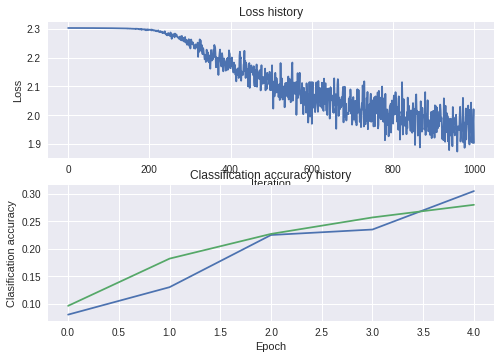

In [11]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

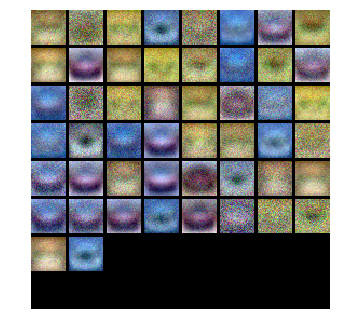

In [12]:
from math import sqrt, ceil

def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.

  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid


# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network.

In [24]:
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################

learning_rates = [5e-4, 5e-3]
reg_strengths = [0.25, 0.35]
results = {}

# Set up ranges of learning rates.
lr_step = (learning_rates[1] - learning_rates[0]) / 5.0
my_lr = np.arange(learning_rates[0], learning_rates[1], lr_step)

# Set up ranges of regularization strengths
reg_step = (reg_strengths[1] - reg_strengths[0]) / 6.0
my_reg = np.arange(reg_strengths[0], reg_strengths[1], reg_step)

# Syntax reminder
#  def train(self, X, y, X_val, y_val,
#            learning_rate=1e-3, learning_rate_decay=0.95,
#            reg=5e-6, num_iters=100,
#            batch_size=200, verbose=False):
#
# returns {
#           'loss_history': loss_history,
#           'train_acc_history': train_acc_history,
#           'val_acc_history': val_acc_history,
#         }
  
total_nets = len(my_lr) * len(my_reg)
curr_net = 1
best_val = -1

input_size = X_train.shape[1]
hidden_size = 100
output_size = 10
    
for i in my_lr:
  for j in my_reg:
    print("Training NN {} out of {}".format(curr_net, total_nets))

    my_net = TwoLayerNet(input_size, hidden_size, output_size)
    net_res = my_net.train(X_train, y_train, X_val, y_val, learning_rate=i, reg=j, num_iters=1000)
    train_acc = net_res['train_acc_history'][-1]
    val_acc = net_res['val_acc_history'][-1]
    print("\tLR: {}, RS: {}, Val Accuracy: {}".format(i, j, val_acc))
    
    hyperparam_tup = (i, j)
    acc_tup = (train_acc, val_acc)
    results[hyperparam_tup] = acc_tup
    
    if (val_acc > best_val):
        best_val = val_acc
        best_net = my_net
    
    curr_net += 1

#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

Training NN 1 out of 30
	LR: 0.0005, RS: 0.25, Val Accuracy: 0.444
Training NN 2 out of 30
	LR: 0.0005, RS: 0.26666666666666666, Val Accuracy: 0.448
Training NN 3 out of 30
	LR: 0.0005, RS: 0.2833333333333333, Val Accuracy: 0.45
Training NN 4 out of 30
	LR: 0.0005, RS: 0.3, Val Accuracy: 0.464
Training NN 5 out of 30
	LR: 0.0005, RS: 0.31666666666666665, Val Accuracy: 0.461
Training NN 6 out of 30
	LR: 0.0005, RS: 0.3333333333333333, Val Accuracy: 0.449
Training NN 7 out of 30
	LR: 0.0014000000000000002, RS: 0.25, Val Accuracy: 0.493
Training NN 8 out of 30
	LR: 0.0014000000000000002, RS: 0.26666666666666666, Val Accuracy: 0.494
Training NN 9 out of 30
	LR: 0.0014000000000000002, RS: 0.2833333333333333, Val Accuracy: 0.465
Training NN 10 out of 30
	LR: 0.0014000000000000002, RS: 0.3, Val Accuracy: 0.46
Training NN 11 out of 30
	LR: 0.0014000000000000002, RS: 0.31666666666666665, Val Accuracy: 0.467
Training NN 12 out of 30
	LR: 0.0014000000000000002, RS: 0.3333333333333333, Val Accurac

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in less


	LR: 0.004100000000000001, RS: 0.25, Val Accuracy: 0.087
Training NN 26 out of 30
	LR: 0.004100000000000001, RS: 0.26666666666666666, Val Accuracy: 0.087
Training NN 27 out of 30
	LR: 0.004100000000000001, RS: 0.2833333333333333, Val Accuracy: 0.402
Training NN 28 out of 30
	LR: 0.004100000000000001, RS: 0.3, Val Accuracy: 0.087
Training NN 29 out of 30
	LR: 0.004100000000000001, RS: 0.31666666666666665, Val Accuracy: 0.087
Training NN 30 out of 30
	LR: 0.004100000000000001, RS: 0.3333333333333333, Val Accuracy: 0.087


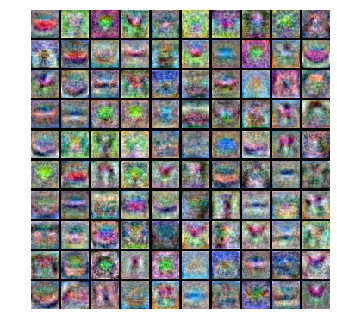

In [25]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [26]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.479


*Many thanks to Stanford CS231n for permission to use their materials!*

